In [2]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [3]:
datafolder = ''

In [4]:
experiment = 'E280' 
model = 'NorESM1-F'
folder = datafolder+'Raw_data/'+model+'/'

In [5]:
if experiment == 'Eoi400':
    dsV = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.vvellvl.nc')
    dsT = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.templvl.nc')
    dsS = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.salnlvl.nc')
    dsr = xr.open_dataset(folder+experiment+'/grid.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.mmflxd.nc')
    dsMOC2 = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499.mmflxd.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.mhflx.nc')
    dstos = xr.open_dataset(folder+experiment+'/NorESM1-F_Eoi400_sst.nc')
    dsice = xr.open_dataset(folder+experiment+'/NorESM1-F_Eoi400_aice.nc')
else:
    dsV = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.vvellvl.nc')
    dsT = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.templvl.nc')
    dsS = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.salnlvl.nc')
    dsr = xr.open_dataset(folder+experiment+'/grid.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.mmflxd.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.mhflx.nc')
    dsMOC2 = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999.mmflxd.nc')
    dstos = xr.open_dataset(folder+experiment+'/NorESM1-F_E280_sst.nc')
    dsice = xr.open_dataset(folder+experiment+'/NorESM1-F_E280_aice.nc')

In [6]:
#Rename to lat and lon to avoid error occurring with interpolation
dsV['lat']=dsr.vlat
dsV['lon']=dsr.vlon

dsT['lat']=dsr.plat
dsT['lon']=dsr.plon

dsS['lat']=dsr.plat
dsS['lon']=dsr.plon

In [7]:
#Create a NetCDF of the region file
f = open(folder+experiment+'/mask.dat', 'r')
i=0
mask = np.zeros([360,385])
for line in f:
    line = line.split()
    if i>=1:
        mask[i-1,:] = [int(a) for a in str(line[0])]
    i = i+1
mask = np.transpose(mask)

da = xr.DataArray(data=mask, dims=["y", "x"], attrs=dict(description="Region mask"))
dsr['region']=da

## Separation MOC and gyre OHT component E280

In [8]:
temp = dsT.templvl[0] #temp in degC
region = dsr.region

#Interpolate velocity to T grid, using 0 for land values to avoid NaN ocean grid cells after interpolation 
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vvellvl[0].fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*temp/temp #Fill land grid cells with NaN values again

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [9]:
#1-D array with spacing of depth grid
ds = dsT.copy(deep=True)

dz = np.zeros(len(ds.depth))
dz[0] = ds.depth[1]-ds.depth[0]
for i in range(1,len(ds.depth)):
    dz[i] = (ds.depth[i]-ds.depth[i-1])
dz = dz*100 #Depth spacing. Units: cm
dsT['DZ'] = xr.DataArray(data=dz, dims=("depth"))
dz = dsT.DZ

#Horizontal grid spacing
DXT = dsr.pdx*100 #convert to cm

In [10]:
cp_sw = 3996.  # [J/kg/K]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

HEAT = (cp_sw*rho_sw*temp).where(region==2)  #  [J/kg/K * kg/cm^3 * degC] = [J/cm^3]

VVEL = vvel.where(region==2) #cm/s

In [11]:
def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return zm

#Zonal mean velocity and heat
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
HEAT_zm = zonal_means(HEAT, DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm_3D)  # azonal heat component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*DXT*dz).sum(dim=['x','depth'])
Haz = (VVEL_prime*HEAT_prime*DXT*dz).sum(dim=['x','depth'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

In [12]:
# auxiliary latitudes for OHT components
lats = dsT.lat.where(region==2).mean('x')

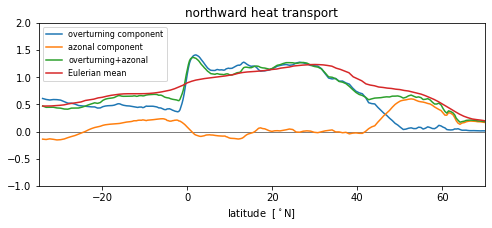

In [13]:
plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov/1e15, label='overturning component')

plt.plot(lats, Haz/1e15, label='azonal component')
plt.plot(lats, (Hov+Haz).squeeze()/1e15, label='overturning+azonal')
plt.plot(dsOHT.lat, dsOHT.mhflx[0,0]/1e15,label='Eulerian mean')
plt.title('northward heat transport')
plt.xlim([-35,70])
plt.ylim([-1,2])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [14]:
if experiment == 'E280':
    dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[104:-50]/1e15), OHTaz=(["lat"], Haz[104:-50]/1e15)), coords = dict(lat = lats[104:-50].values))
elif experiment == 'Eoi400':
    dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[104:-50]/1e15), OHTaz=(["lat"], Haz[104:-50]/1e15)), coords = dict(lat = lats[104:-50].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC streamfunction

In [15]:
#Mask (almost) zero values 
a = dsMOC.mmflxd[0,0]/1e9
b = a.where(a<-1e-6).fillna(0)+a.where(a>1e-6).fillna(0)
c = b.where(b!=0)

In [16]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), c.values)), coords = dict(z = dsMOC.depth.values, lat = dsMOC.lat.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## Annual AMOC streamfunction (100 years)

In [17]:
#Mask (almost) zero values
a = dsMOC2.mmflxd[:,0]/1e9
b = a.where(a<-1e-6).fillna(0)+a.where(a>1e-6).fillna(0)
c = b.where(b!=0)

In [18]:
if experiment == 'E280':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), c.values)), coords = dict(time = np.arange(1900, 2000), z = dsMOC.depth.values, lat = dsMOC.lat.values))
else:
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), c.values)), coords = dict(time = np.arange(2400, 2500), z = dsMOC.depth.values, lat = dsMOC.lat.values))
    
xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## 100-yr average total Atlantic OHT

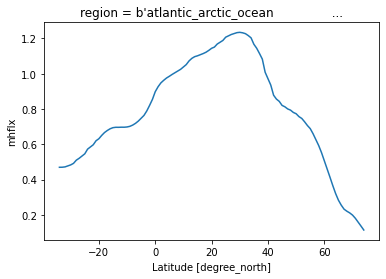

In [19]:
(dsOHT.mhflx[0,0]/1e15).plot()
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), dsOHT.mhflx[0,0].values/1e15)), coords = dict(lat = dsOHT.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## Annual SST timeseries (100 years)

In [20]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dstos, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

tos = regridder(dstos.sst)
tosann = np.zeros([100,180,360])

for i in range(0,100):
    tosann[i] = tos[0+i*12:12+i*12].mean(dim='time')

if experiment == 'E280':
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(1900, 2000), lat = tos.latitude.values, lon = tos.longitude.values))
else:
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(2400, 2500), lat = tos.latitude.values, lon = tos.longitude.values))
    
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean SSS (regridded)

In [21]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
sss = regridder(dsS.salnlvl[0,0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean sea ice (regridded)

In [22]:
dsi = dsice.drop('time') # To avoid error with adding different months together

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

djf = (dsi.aice[11:1200:12]+dsi.aice[0:1200:12]+dsi.aice[1:1200:12])/3
si_djf = regridder(djf.mean(dim='time'))

mam = (dsi.aice[2:1200:12]+dsi.aice[3:1200:12]+dsi.aice[4:1200:12])/3
si_mam = regridder(mam.mean(dim='time'))

jja = (dsi.aice[5:1200:12]+dsi.aice[6:1200:12]+dsi.aice[7:1200:12])/3
si_jja = regridder(jja.mean(dim='time'))

son = (dsi.aice[8:1200:12]+dsi.aice[9:1200:12]+dsi.aice[10:1200:12])/3
si_son = regridder(son.mean(dim='time'))

si = (si_djf+si_mam+si_jja+si_son)/4
dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.a

## 100-yr mean top 100 m salinity (regridded)

In [23]:
def makedz(z):
    dz = np.zeros(len(z)-1)
    for i in range(1,len(z)):
        dz[i-1] = (z[i]-z[i-1])
    return xr.DataArray(data=dz, dims=("depth"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.depth[0:13])

s100m = regridder(dsS.salnlvl[0,0:12].weighted(weights).mean(dim='depth'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity Atlantic

In [24]:
salt_atl = dsS.salnlvl[0]

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.depth.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature Atlantic

In [25]:
temp_atl = dsT.templvl[0]

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')
dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.depth.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [26]:
if experiment =='E280':
    dsu = xr.open_dataset(folder+experiment+'/Atm/NorESM1-F_E280_U.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/NorESM1-F_E280_V.nc')
else:
    dsu = xr.open_dataset(folder+experiment+'/Atm/NorESM1-F_Eoi400_U.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/NorESM1-F_Eoi400_V.nc')

In [27]:
ua = dsu.U[:,0].mean(dim='time')
va = dsv.V[:,0].mean(dim='time')

In [28]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
